<a href="https://colab.research.google.com/github/achmadbauravindah/Classification-NN-TitanicDataset/blob/main/Classification_NN_TitanicDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
_ = ! pip install scikeras -q

In [ ]:
import tensorflow as tf 
from tensorflow.keras.models import Sequential # Sequential Model Keras
from scikeras.wrappers import KerasClassifier # Keras Wrapper to Sci-kit Model
from tensorflow.keras.layers import Input, Dense # Layer

import matplotlib.pyplot as plt # Plotting
import numpy as np # Array
import pandas as pd # Dataframe
from sklearn.impute import KNNImputer # Missing Value
from sklearn.preprocessing import MinMaxScaler # Normalisasi data
from sklearn.model_selection import train_test_split # Split data
from sklearn.metrics import accuracy_score # Evaluation Metrics
from sklearn.model_selection import GridSearchCV # Grid Search 
import time

# 1. Preprocessing

In [ ]:
# Get data from Kaggle
_ = ! git clone https://github.com/achmadbauravindah/ravin_kaggle_credential.git # get credential from kaggle
_ = ! pip install kaggle # install kaggle on device
_ = ! mkdir ~/.kaggle # make hidden folder .kaggle to configure credential
_ = ! cp ravin_kaggle_credential/kaggle.json ~/.kaggle/ # copy credential from github to .kaggle folder
_ = ! chmod 600 ~/.kaggle/kaggle.json # change access
_ = ! kaggle datasets download titanic-dataset # which dataset to download
_ = ! unzip titanic-dataset # unzip if data zipped

In [ ]:
# Load dataset from storage
PATH = "Titanic Dataset.csv"
raw_data = pd.read_csv(PATH, delimiter=';')

In [ ]:
raw_data.isnull().sum()

PassengerId       0
Survived          0
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

In [ ]:
raw_data.shape

(1309, 12)

In [ ]:
def dropColumns(data):
  data = data.drop(['PassengerId'], axis=1) # Karena tidak ada korelasi dengan data
  data = data.drop(['Name'], axis=1) # Karena tidak ada korelasi dengan data
  data = data.drop(['Ticket'], axis=1) # Karena tidak ada korelasi dengan data
  data = data.drop(['Cabin'], axis=1) # Karena values banyak yang missing
  return data

In [ ]:
def encodingData(data): # Encode / Merubah Kategorikal menjadi Numerikal
  data['Sex'].replace({ 'male':0, 'female':1}, inplace=True)
  data['Embarked'].replace({ 'C':0, 'Q':1, 'S':2}, inplace=True)
  return data

In [ ]:
def handleMissingValues(data):
  k = 5
  imputer = KNNImputer(n_neighbors=k)
  data = pd.DataFrame(imputer.fit_transform(data), columns = data.columns)
  return data

In [ ]:
def normalizeData(data):
  data = np.array(data) # Ubah ke Numpy
  data = np.rint(data) # Membulatkan data
  data = pd.DataFrame(data) # Ubah ke Pandas
  scaler = MinMaxScaler()
  data = pd.DataFrame(scaler.fit_transform(data), columns = data.columns)
  return data

In [ ]:
def sliceLabel(data):
  X = data
  y = data.pop(0)
  return X, y

In [ ]:
def toNumpy(X, y):
  X = np.array(X)
  y = np.array(y)
  return X, y

In [ ]:
titanic_data = raw_data
titanic_data = dropColumns(titanic_data)
titanic_data = encodingData(titanic_data)
titanic_data = handleMissingValues(titanic_data)
titanic_data = normalizeData(titanic_data)
X, y = sliceLabel(titanic_data) # Memisahkan data input dengan data label
X, y = toNumpy(X ,y) # Mengubah data ke bentuk array numpy

# 2. Processing

In [ ]:
# PARAMS
# define the grid search parameters
# EPOCHS = [25, 50, 75, 100]
# OPTIMIZER = ['Adam', 'SGD', 'RMSProp']
# LR = [0.01, 0.001, 0.0001, 0.00001]
NEURONS = [12, 18, 24, 60]
# create params to try each model
param_grid = dict( 
                  # optimizer = OPTIMIZER, 
                  # optimizer__learning_rate = LR, 
                  # epochs = EPOCHS,
                  model__neurons=NEURONS,
                  )

In [ ]:
def NN(neurons):
  # FCL
  model = Sequential([
            Input(shape=(X.shape[1],)),
            Dense(7, activation='relu'),
            Dense(neurons, activation='relu'),
            Dense(1, activation='sigmoid')
  ])
  model.compile(loss='binary_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
# Sci-kit Wrapper for Keras
model = KerasClassifier(model=NN, verbose=1)

# create tuning params model with grid
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=10)
# train all params
grid_result = grid.fit(X, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

41/41 [==============================] - 1s 3ms/step - loss: 0.6046 - accuracy: 0.6455
Best: 0.720323 using {'model__neurons': 60}
0.712748 (0.088079) with: {'model__neurons': 12}
0.675138 (0.100307) with: {'model__neurons': 18}
0.655437 (0.028354) with: {'model__neurons': 24}
0.720323 (0.074789) with: {'model__neurons': 60}


In [ ]:
# Best Model: 0.851832 using {'epochs': 25, 'model__neurons': 24, 'optimizer': 'RMSProp', 'optimizer__learning_rate': 0.01}
def BestModelBackpro(X, y):
  lr = 0.01
  neuron_hidden = 60
  activate_function = 'sigmoid'
  # Container untuk menampung semua layer
  modelBackpro = Sequential()

  # Menambahkan layer pada container
  modelBackpro.add(Dense(6, input_shape = (7,))) # Input Layer
  modelBackpro.add(Dense(neuron_hidden, activation='relu')) # Hidden Layer ke-1
  modelBackpro.add(Dense(1, activation = activate_function)) # Output Layer

  optimizer = tf.keras.optimizers.RMSprop(lr)
  loss = tf.keras.losses.MeanSquaredError()

  # Compile ModelBackpro / Proses modelBackpro
  modelBackpro.compile(loss = loss, metrics=['accuracy'], optimizer = optimizer)

  return modelBackpro

In [ ]:
BestModelBackpro = BestModelBackpro(X, y)

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

def trainModelWithKFlodBackpro(n_folds, model, X, y):
  kfold = KFold(n_splits=n_folds, shuffle=True)

  # Simpan Metrics tiap fold
  acc_per_fold = []
  cm_per_fold = []
  precision_per_fold = []
  recall_per_fold =[]
  f1_per_fold = []

  for train_i, test_i in kfold.split(X, y):
    X_train = X[train_i]
    y_train = y[train_i]
    X_test = X[test_i]
    y_test = y[test_i]
    
    model.fit(X_train,
              y_train,
              batch_size = 25,
              epochs = 25,
              verbose = 0,
              shuffle = True,
              steps_per_epoch = int(X_train.shape[0]/25),
              )
    
    y_test_predicted = model.predict(X_test)
    y_test_predicted = (y_test_predicted > 0.5).astype(int)
    cm, accuracy, precision, recall, f1 = getMetrics(y_test, y_test_predicted)

    cm_per_fold.append(cm)
    acc_per_fold.append(accuracy)
    precision_per_fold.append(precision)
    recall_per_fold.append(recall)
    f1_per_fold.append(f1)
  return acc_per_fold, cm_per_fold, precision_per_fold, recall_per_fold, f1_per_fold

In [ ]:
def getMetrics(y_test_actual, y_test_predict):
  cm = confusion_matrix(y_test_actual, y_test_predict)
  accuracy = accuracy_score(y_test_actual, y_test_predict)
  recall = recall_score(y_test_actual, y_test_predict, average='macro')
  precision = precision_score(y_test_actual, y_test_predict, average='macro')
  f1 = f1_score(y_test_actual, y_test_predict, average='macro')
  return cm, accuracy*100, precision*100, recall*100, f1*100

In [ ]:
def ploting(cm_per_fold, 
            acc_per_fold, 
            precision_per_fold, 
            recall_per_fold, 
            f1_per_fold
            ):                    
  index = 0
  for cm in cm_per_fold:
    acc = acc_per_fold[index]
    precision = precision_per_fold[index]
    recall = recall_per_fold[index]
    f1 = f1_per_fold[index]
    print('------------------------------------------------------------------------')
    print(f'> Fold {index+1} - Accuracy: {acc}%')
    # Show Precision
    print('Precision: {:.2f}%'.format(precision))
    # Show Recall
    print('Recall: {:.2f}%'.format(recall))
    # Show F1Score
    print('F1 Score: {:.2f}%'.format(f1))
    # Show Confusion Matrix
    fig, ax = plt.subplots(figsize=(3, 3), constrained_layout="True")
    ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center')        
    plt.xlabel('Predictions', fontsize=12)
    plt.ylabel('Actuals', fontsize=12)
    plt.title('Confusion Matrix', fontsize=12)
    plt.show()
    index+=1
  print('------------------------------------------------------------------------')
  print("RATA-RATA SEMUA 'METRICS' UNTUK SEMUA FOLD:")
  print(f'> Accuracy: {np.mean(acc_per_fold)}')
  print(f'> Precision: {np.mean(precision_per_fold)}%')
  print(f'> Recall: {np.mean(recall_per_fold)}%')
  print(f'> F1Score: {np.mean(f1_per_fold)}%')

  print('------------------------------------------------------------------------')

In [ ]:
def showAccuracyPlotFold(accuracy, epoch_time):
  foldKeN = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"]
  Akurasi = accuracy

  fig, ax = plt.subplots()
  ax.plot(foldKeN, Akurasi)

  ax.set(xlabel='Fold - n', ylabel='Akurasi (%)',
        title= 'Hasil Akurasi Epoch = 25 ({:.2f} s)'.format(epoch_time))
  ax.grid()
  
  plt.show()

------------------------------------------------------------------------
> Fold 1 - Accuracy: 83.20610687022901%
Precision: 83.88%
Recall: 78.58%
F1 Score: 80.21%


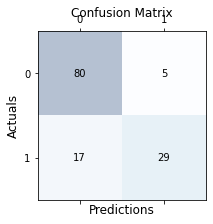

------------------------------------------------------------------------
> Fold 2 - Accuracy: 87.78625954198473%
Precision: 86.85%
Recall: 86.85%
F1 Score: 86.85%


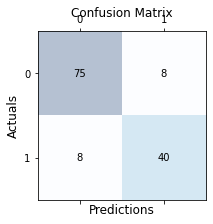

------------------------------------------------------------------------
> Fold 3 - Accuracy: 89.31297709923665%
Precision: 89.79%
Recall: 88.00%
F1 Score: 88.68%


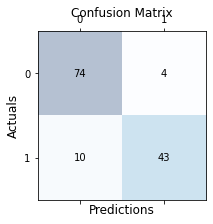

------------------------------------------------------------------------
> Fold 4 - Accuracy: 83.20610687022901%
Precision: 81.98%
Recall: 80.58%
F1 Score: 81.18%


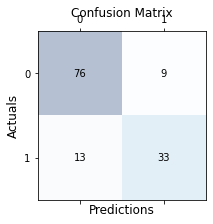

------------------------------------------------------------------------
> Fold 5 - Accuracy: 82.44274809160305%
Precision: 81.91%
Recall: 79.56%
F1 Score: 80.43%


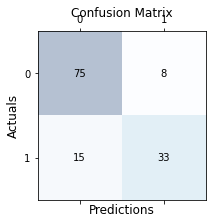

------------------------------------------------------------------------
> Fold 6 - Accuracy: 87.02290076335878%
Precision: 85.37%
Recall: 86.41%
F1 Score: 85.83%


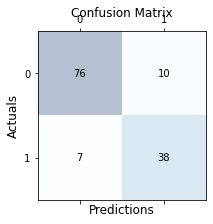

------------------------------------------------------------------------
> Fold 7 - Accuracy: 87.78625954198473%
Precision: 89.07%
Recall: 86.57%
F1 Score: 87.24%


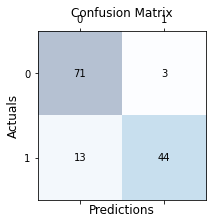

------------------------------------------------------------------------
> Fold 8 - Accuracy: 86.25954198473282%
Precision: 86.97%
Recall: 85.22%
F1 Score: 85.74%


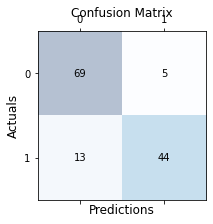

------------------------------------------------------------------------
> Fold 9 - Accuracy: 87.02290076335878%
Precision: 86.83%
Recall: 86.08%
F1 Score: 86.40%


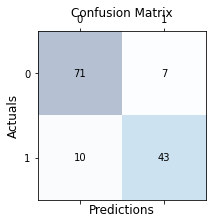

------------------------------------------------------------------------
> Fold 10 - Accuracy: 90.0%
Precision: 88.61%
Recall: 88.09%
F1 Score: 88.34%


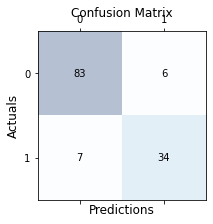

------------------------------------------------------------------------
RATA-RATA SEMUA 'METRICS' UNTUK SEMUA FOLD:
> Accuracy: 86.40458015267176
> Precision: 86.1263057071371%
> Recall: 84.59283900022719%
> F1Score: 85.09027778290134%
------------------------------------------------------------------------


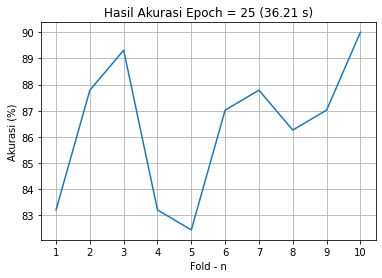

Waktu Komputasi Logistic Regression (36.21 s)


In [ ]:
# Model Backpro
start = time.process_time()
acc_per_fold, cm_per_fold, precision_per_fold, recall_per_fold, f1_per_fold = trainModelWithKFlodBackpro(10, BestModelBackpro, X, y)
epoch_time = time.process_time() - start

ploting(cm_per_fold, 
        acc_per_fold, 
        precision_per_fold, 
        recall_per_fold, 
        f1_per_fold
        )
showAccuracyPlotFold(acc_per_fold, epoch_time)
print('Waktu Komputasi Logistic Regression ({:.2f} s)'.format(epoch_time))